# cs7324 Lab 6 - Convolutional Neural Networks

#### Chip Henderson - 48996654 

Write something here about the dataset.

There were two I downloaded. One for binary:
https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

And one for classification:
https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/code

## Preparation

In [110]:
# Source modified from in-class notebook
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

print('Tensorflow version:',tf.__version__)



Tensorflow version: 2.12.0


In [111]:
# Comment out when running on surface
# tf.test.is_built_with_cuda()
# tf.config.list_physical_devices('GPU')

In [112]:
train_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_dataset\Training"
test_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_dataset\Testing"

# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
ds_train = tf.keras.utils.image_dataset_from_directory(
    train_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32, # changed from default 32
    image_size=(128, 128), # Downsample the images
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    test_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32, # changed from default 32
    image_size=(128, 128), # Downsample the images
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 2870 files belonging to 4 classes.


Found 394 files belonging to 4 classes.


**Revisit this to see how we can make the labels appear as their string versions**

C:\Users\Chip\AppData\Local\Temp\ipykernel_1784\4196770863.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4,i+1)


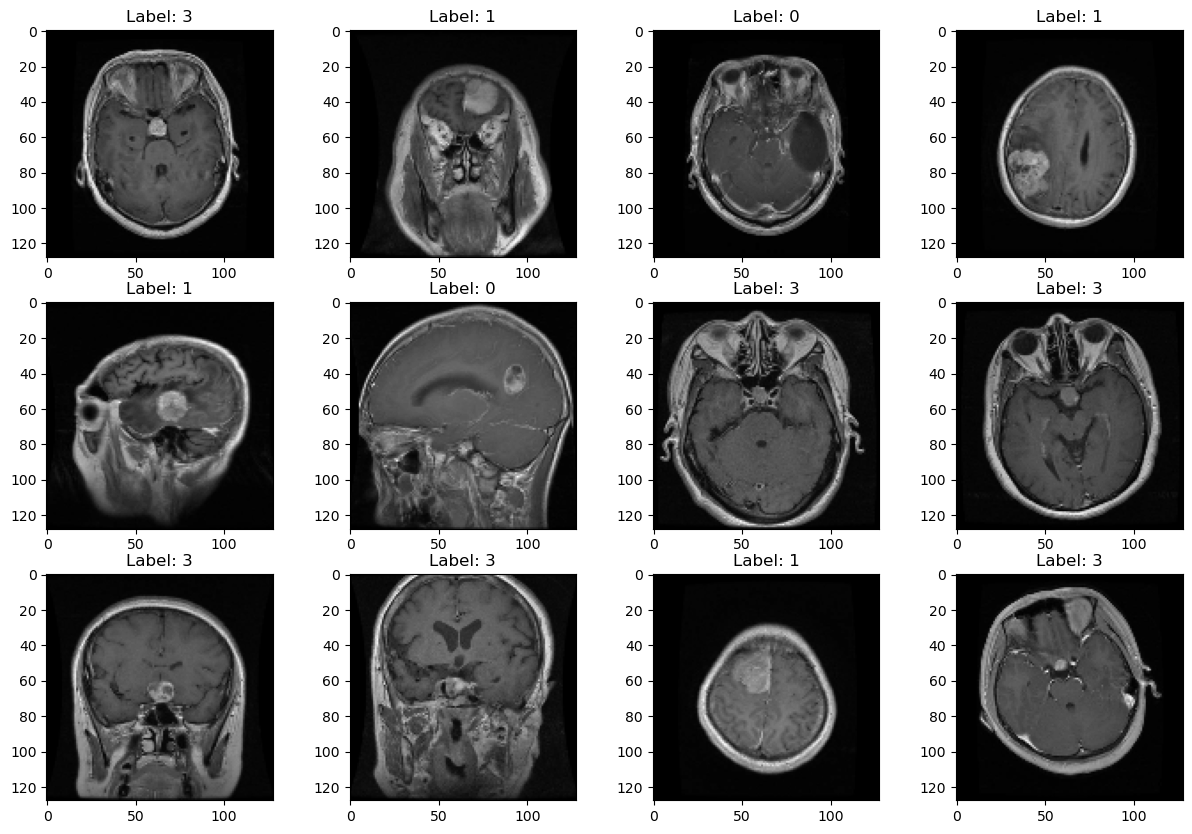

In [113]:
# Source: Code re-use from Lab 2 and 5

import matplotlib.pyplot as plt
class_names = ["Glioma", "Meningioma", "Healthy", "Pituitary"]

plt.subplots(figsize=(15, 10))

# Iterate through the dataset
for i, (images, labels) in enumerate(ds_train.take(12)):
    plt.subplot(3,4,i+1)
    # Display the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    # label_str = class_names[labels[0].numpy()]
    plt.title(f"Label: {np.argmax(labels)}")
        
plt.show()

Let's check out the balance of samples.
ds_test

### Metrics

I fully expect this to be a very challenging dataset. Just looking at these images you have different orientations which will challenge the ability to reliably detect edges and locations. Where there are positive tumor detection, it is difficult to visually see the difference in what those types of tumors are. 

To think about this in greater detail, I'll discuss what I believe the business case of a model like this would be. Unlike my previous breast cancer dataset in lab 5, this model is not focused on the lethality of the cancer. This model should be able to relieve the burden on radiologists by identifying patients with tumors. A study in Applied Radiology in 2015 indicated that radiologists need to interpret one image every 3-4 seconds in an eight hour workday (https://appliedradiology.com/articles/the-radiologist-s-gerbil-wheel-interpreting-images-every-3-4-seconds-eight-hours-a-day-at-mayo-clinic#:~:text=That%20is%20what%20radiologists%20interpreting,seconds%20to%20meet%20workload%20demands). Some of these images which are displayed above allow for an easy visual assessment of wehther a tumor is present, many do not. So the intent of my model from a business case perspective, is to identify that a tumor is present, which can create a subset of patients for further detailed evaluation. This could help alleviate the burden on radiologists and identifying the specific class is simply added benefit.

With this in mind, now my concern becomes more focused on accidentally declaring a person with a tumor to be healthy, a false negative. So I'd prefer a metric that encourages more false positives so that only when confidence is very high that a patient is healthy, it doesn't receive a more detailed review. The metric that most closely aligns with this desire is recall, as it emphasizes performance of the model with respect to the true positive rate. 

#### Data Split

This dataset came pre-split in training and testing divisions. The total count of each is 2,870 training samples and 394 testing samples. I'd like to see how many of each category exists in my datasets.

The number of Glioma tumors in the training data is 826
The number of Meningioma tumors in the training data is 822
The number of Healthy scans in the training data is 395
The number of Pituitary tumors in the training data is 827

The number of Glioma tumors in the testing data is 100
The number of Meningioma tumors in the testing data is 115
The number of Healthy scans in the testing data is 105
The number of Pituitary tumors in the testing data is 74


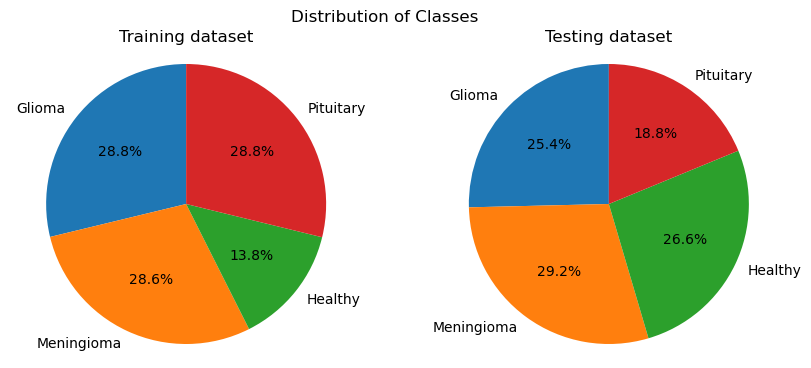

In [114]:
train_cancer_type = []
test_cancer_type = []

batches_train = [label.numpy().astype(int) for (image,label) in ds_train] # get training batches
batches_test = [label.numpy().astype(int) for (image,label) in ds_test] # get testing batches

# Get the individual cancer types from each dataset
for train_batch in batches_train:
    for train_label in train_batch:
        train_cancer_type.append(np.argmax(train_label))

for test_batch in batches_test:
    for test_label in test_batch:
        test_cancer_type.append(np.argmax(test_label))

print(f"The number of Glioma tumors in the training data is {train_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the training data is {train_cancer_type.count(1)}")
print(f"The number of Healthy scans in the training data is {train_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the training data is {train_cancer_type.count(3)}\n")

print(f"The number of Glioma tumors in the testing data is {test_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the testing data is {test_cancer_type.count(1)}")
print(f"The number of Healthy scans in the testing data is {test_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the testing data is {test_cancer_type.count(3)}")

# Plot the data usig a pie plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
pie_data = [train_cancer_type.count(0), train_cancer_type.count(1), train_cancer_type.count(2), train_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Training dataset')

plt.subplot(1,2,2)
pie_data = [test_cancer_type.count(0), test_cancer_type.count(1), test_cancer_type.count(2), test_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Testing dataset')

plt.suptitle('Distribution of Classes')

plt.show()

From the above chart I can see that there are more healthy samples in the testing dataset and fewer pituitary tumors. Also, to perform some basic math, my test/train split is roughly 88/12.

This distribution of values isn't terrible. Specifically, I'm not seeing a gross underrepresentation of one particular class. Still, this distribution may indicate I should look at performing a stratified KFold cross validation to ensure the balance differences seen between the classes are the same in my test and training data.

Let's take a look at combining and resplitting the data.

In [115]:
'''
# Source: Chat-GPT for info on combining datasets and implementing stratified_kfold after I'd selected it
# Note this is splitting based on batches of 32...
from sklearn.model_selection import StratifiedKFold

# Step 1: Combine the datasets
ds_combined = ds_train.concatenate(ds_test)
ds_combined = ds_combined.shuffle(buffer_size=len(ds_combined), seed=42, reshuffle_each_iteration=False)

# print(len(ds_combined))

# Step 2: Prepare labels for stratified k-fold
labels = []
for _, label in ds_combined.unbatch():
    labels.append(tf.argmax(label).numpy())
labels = np.array(labels)

# Step 3: Perform stratified k-fold cross-validation

kfold_splits = 8  # 3,264 total images, each fold has 272 images with 12 or 408 with 8
stratified_kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=5)

for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(labels)), labels)):
    train_dataset = ds_combined.skip(len(ds_combined) // kfold_splits)
    train_dataset = train_dataset.take(len(train_dataset) * (kfold_splits - 1) // kfold_splits)
    
    validation_dataset = ds_combined.take(len(ds_combined) // kfold_splits)

    # Train your model using train_dataset and validate using validation_dataset
    # ...

    print(f"Fold {fold + 1}: Training on {len(train_dataset)} samples, validating on {len(validation_dataset)} samples")
'''


'\n# Source: Chat-GPT for info on combining datasets and implementing stratified_kfold after I\'d selected it\n# Note this is splitting based on batches of 32...\nfrom sklearn.model_selection import StratifiedKFold\n\n# Step 1: Combine the datasets\nds_combined = ds_train.concatenate(ds_test)\nds_combined = ds_combined.shuffle(buffer_size=len(ds_combined), seed=42, reshuffle_each_iteration=False)\n\n# print(len(ds_combined))\n\n# Step 2: Prepare labels for stratified k-fold\nlabels = []\nfor _, label in ds_combined.unbatch():\n    labels.append(tf.argmax(label).numpy())\nlabels = np.array(labels)\n\n# Step 3: Perform stratified k-fold cross-validation\n\nkfold_splits = 8  # 3,264 total images, each fold has 272 images with 12 or 408 with 8\nstratified_kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=5)\n\nfor fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(labels)), labels)):\n    train_dataset = ds_combined.skip(len(ds_combi

## Modeling

In [116]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from copy import copy

For the first model, I need to provide a data augmentation technique. In order to better understand the impact of such additions, I'd like to visualize some of the results of their application. 

C:\Users\Chip\AppData\Local\Temp\ipykernel_1784\3780908595.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)


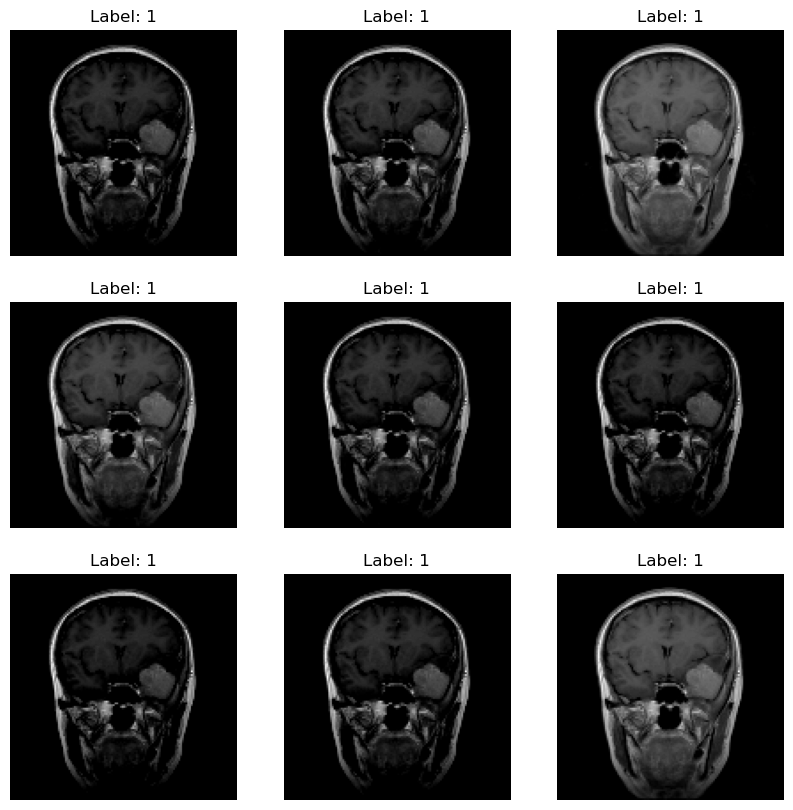

In [117]:
# Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
# from tensorflow.keras.layers import RandomContrast, RandomBrightness

img_augmentation = Sequential(
    [
        # layers.RandomRotation(factor=0.15),
        # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        # layers.RandomFlip(),
        layers.RandomBrightness(factor=(-0.3,0)),
        layers.RandomContrast(factor=0.2)
    ],
    name="img_augmentation",
)

plt.subplots(figsize=(10, 10))
for i, (images, labels) in enumerate(ds_train.take(1)):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(images[0], axis=0))
        plt.imshow(aug_img.numpy().squeeze(), cmap='gray')
        # plt.imshow(images[0].numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(labels)}")
        plt.axis("off")

Here, I'm focusing on brightness and contrast. Based on a review of the images in the dataset, many times the tumor indications show up very brightly. My hope is that by adjusting the contrast and the brightness I can further emphasize deliniations between healthy tissue and tumors.

Most of the images in the dataset are relatively bright. Therefore I selected a range (min,max) values which would darken the images. This Should improve performance because brigheter artifacts like the tumors and skull aren't as severely affected by dimming the image. Conversely, normal brain tissue which typically shows up in varrying shades of gray on the scans, will be significantly darkened. I anticipate that this will allow the model to identify edges more clearly which could help with diagnosis.

I also experimented with contrast, but found the results to be somewhat minimal visually no matter the factor used. So I'm using a random implementation her for that value.

In [118]:
# Source: modified from in class lecture
# I'll use this function repeatedly throughout the lab
from sklearn import metrics as mt
from matplotlib import pyplot as plt
# from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, ds_test, title_text=''):
    plt.figure(figsize=(15,5))
    # convert dataset to test set we can use with sklearn.metrics
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    yhat = np.argmax(net.predict(ds_test), axis=1)
    # acc = mt.accuracy_score(y_test,yhat.squeeze())
    acc = mt.recall_score(y_test,yhat.squeeze(),average='micro') # want to focus on recall
    cm = mt.confusion_matrix(y_test,yhat.squeeze())
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names,yticklabels=class_names)
    plt.title(f'{title_text} {acc:.4f}')
    

#### Architecture 1 - Model 1 
I'm reusing a model from lecture for this first architecture. I've modified it by bringing in the data augmentation values as the first two layers. These are followed by a convolutional layer with a 3x3 kernel size and 32 filters, then by another convolutional layer with a 3x3 filter and 64 filters. Finally, a pooling layer with size 2, 2 is applied. Then the data is flattened for the MLP portion of the model with 64 neurons with Relu and an ouput layer of 4 classes with a softmax activation.

My loss function will be Categorical Cross-entroy and as discussed above, my metric will be focused on Recall. My optimizer is rmsprop.

In [119]:
%%time
# Source: Modified from notebook 12a

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomContrast, RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

NUM_CLASSES = 4
arch1_cnn1 = Sequential()

# add in augmentations directly
arch1_cnn1.add( RandomBrightness(factor=(-0.3,0)) )
arch1_cnn1.add( RandomContrast(factor=0.2) )

# let's start with an AlexNet style convolutional phase
arch1_cnn1.add(Conv2D(filters=32,
                input_shape = (128,128),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
arch1_cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
                
arch1_cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
arch1_cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
arch1_cnn1.add(Flatten())
arch1_cnn1.add(Dense(64, activation='relu'))
arch1_cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
arch1_cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
arch1_cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

arch1_cnn1.build((None,128,128,1))

arch1_cnn1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_18 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_18 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

In [120]:
%%time 
history_arch1_cnn1 = arch1_cnn1.fit(
        ds_train,
        batch_size=32,
        epochs=30,
        verbose=1,
        validation_data=ds_test
        )

Epoch 1/15


90/90 [==============================] - 67s 721ms/step - loss: 16.5685 - recall: 0.1603 - val_loss: 2.9794 - val_recall: 0.1929
Epoch 2/15
90/90 [==============================] - 67s 739ms/step - loss: 1.1035 - recall: 0.3418 - val_loss: 2.3115 - val_recall: 0.2056
Epoch 3/15
90/90 [==============================] - 66s 729ms/step - loss: 1.2557 - recall: 0.4721 - val_loss: 10.4827 - val_recall: 0.2614
Epoch 4/15
90/90 [==============================] - 68s 748ms/step - loss: 0.8798 - recall: 0.5603 - val_loss: 3.3510 - val_recall: 0.3274
Epoch 5/15
90/90 [==============================] - 67s 745ms/step - loss: 1.0194 - recall: 0.6087 - val_loss: 5.9324 - val_recall: 0.3959
Epoch 6/15
90/90 [==============================] - 71s 790ms/step - loss: 0.7529 - recall: 0.6551 - val_loss: 2.7593 - val_recall: 0.5254
Epoch 7/15
90/90 [==============================] - 72s 793ms/step - loss: 0.6454 - recall: 0.7160 - val_loss: 2.9340 - val_recall: 0.3959
Epoch 8/15
90/90 [==================

What I'm getting out of it his initial MLP for this data is what I expected. With an accuracy of ~29% the model is doing only marginally better than chance. This is expected for a few reasons. As I mentioned previously this is a difficult dataset. This MLP model is just about as simple as sit gets, a pretty blunt tool for this kind of work. Throughout the next few models I'm going to try and improve on this result. However, I expect some limitations based on my hardware which is a Microsoft Surface Pro 8. 

What this dataset probably needs is something on the sophistication level of ResNet50. However running that model would take a very long time with my system and I'd like to see how much improvement I can get on this basic MLP with just some CNNs and augmentations.

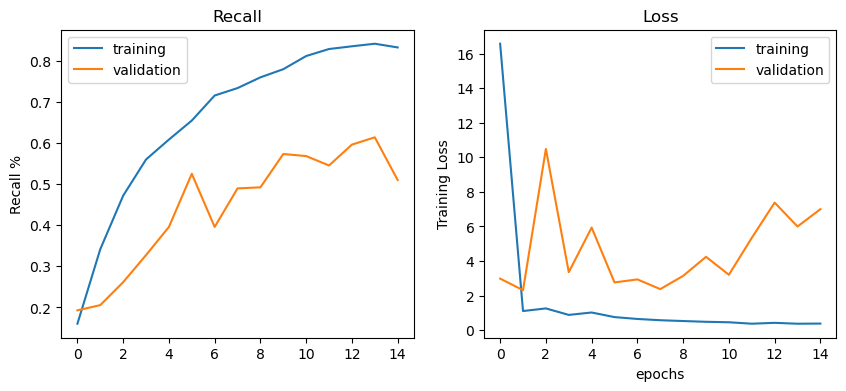

In [121]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch1_cnn1.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch1_cnn1.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch1_cnn1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch1_cnn1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
#plt.show()

13/13 [==============================] - 3s 164ms/step


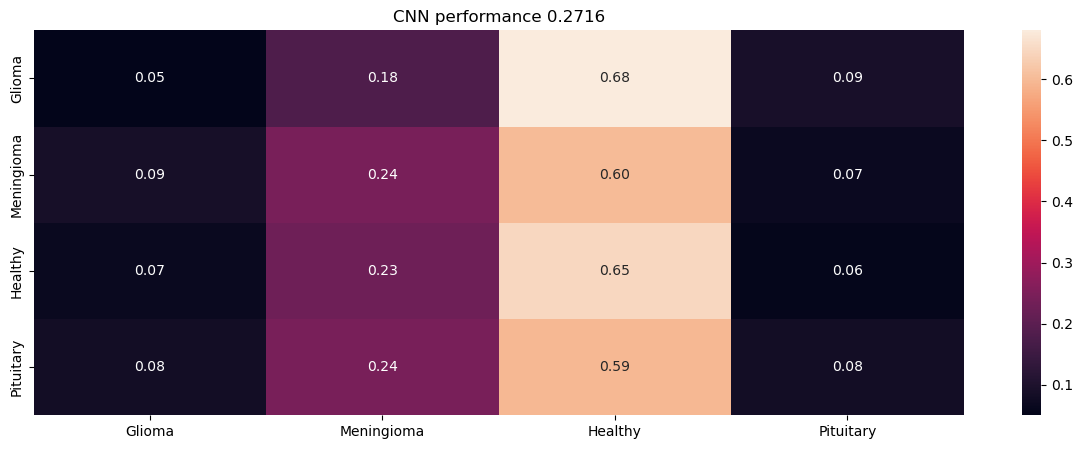

In [122]:
summarize_net(arch1_cnn1, ds_test, title_text='CNN performance')

What I'm looking for in my confusion matrix to support my metric of recall is how many times I have a tumor in the image, Glioma, Meningioma, Pituitary, on the left hand side that is miscategorized as healthy on the bottom side. And in this case that appears to be very rare. While that's good for not letting False Negatives through, I'm concerned that this doesn't help alleviate the burden on radiologists which is really the intent of my model.

#### Architecture 1 - Model 2

In model 2 I have changed the optimizer to adam and really that's about it.

In [123]:
%%time
# Source: Modified from notebook 12a

# NUM_CLASSES = 4
arch1_cnn2 = Sequential()

# add in augmentations directly
arch1_cnn2.add( RandomBrightness(factor=(-0.3,0)) )
arch1_cnn2.add( RandomContrast(factor=0.2) )

# let's start with an AlexNet style convolutional phase
arch1_cnn2.add(Conv2D(filters=32,
                input_shape = (128,128),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
arch1_cnn2.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
                
arch1_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
arch1_cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
arch1_cnn2.add(Flatten())
arch1_cnn2.add(Dense(64, activation='relu'))
arch1_cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
arch1_cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
arch1_cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

arch1_cnn2.build((None,128,128,1))

arch1_cnn2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_19 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_19 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

In [124]:
%%time 
history_arch1_cnn2 = arch1_cnn2.fit(
        ds_train,
        batch_size=32,
        epochs=30,
        verbose=1,
        validation_data=ds_test
        )

Epoch 1/15


90/90 [==============================] - 109s 1s/step - loss: 29.9745 - recall: 0.0983 - val_loss: 1.5519 - val_recall: 0.0431
Epoch 2/15
90/90 [==============================] - 109s 1s/step - loss: 1.0328 - recall: 0.3052 - val_loss: 1.8773 - val_recall: 0.2183
Epoch 3/15
90/90 [==============================] - 100s 1s/step - loss: 0.8288 - recall: 0.5003 - val_loss: 2.4269 - val_recall: 0.3782
Epoch 4/15
90/90 [==============================] - 93s 1s/step - loss: 0.6675 - recall: 0.6331 - val_loss: 2.0370 - val_recall: 0.3782
Epoch 5/15
90/90 [==============================] - 79s 873ms/step - loss: 0.5175 - recall: 0.7230 - val_loss: 3.9186 - val_recall: 0.5102
Epoch 6/15
90/90 [==============================] - 78s 867ms/step - loss: 0.4460 - recall: 0.7833 - val_loss: 2.3274 - val_recall: 0.4949
Epoch 7/15
90/90 [==============================] - 79s 872ms/step - loss: 0.3900 - recall: 0.8098 - val_loss: 2.7170 - val_recall: 0.5888
Epoch 8/15
90/90 [============================

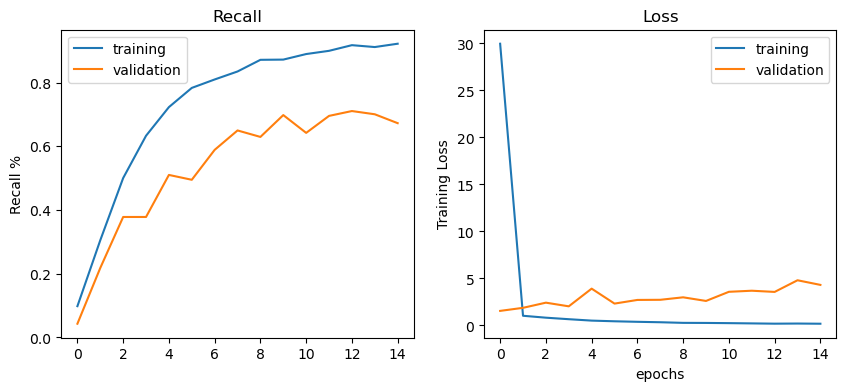

In [125]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch1_cnn2.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch1_cnn2.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch1_cnn2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch1_cnn2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
#plt.show()

13/13 [==============================] - 2s 156ms/step


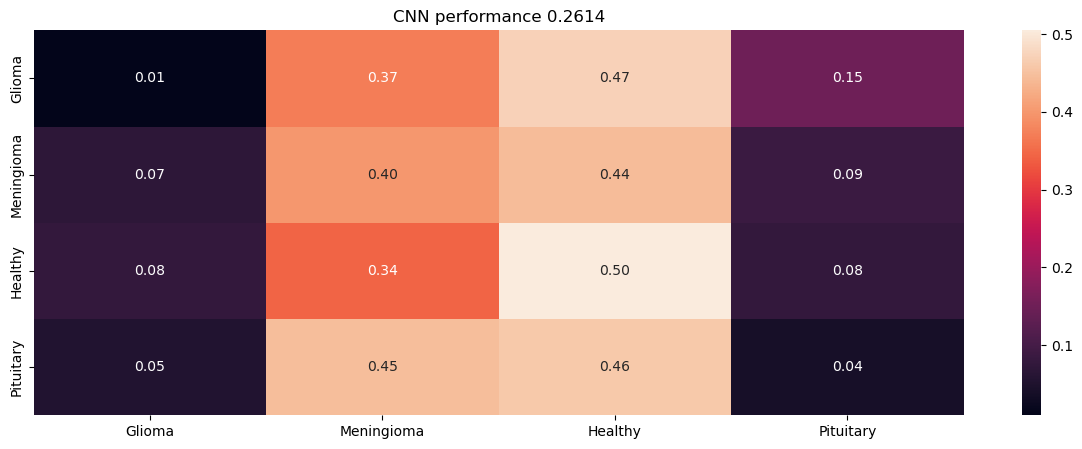

In [126]:
summarize_net(arch1_cnn2, ds_test, title_text='CNN performance')

#### Architecture 2 - Model 1

In the architecture below, I've added two dense layers in the ML portion to provide a smoother step down to my 4 classification groups. I've kept the optimizer and loss function the same as in my first model.

In [127]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

arch2_cnn1 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    arch2_cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    arch2_cnn1.add( MaxPooling2D(pool_size=(2, 2) ) )
    

# add one layer on flattened output
arch2_cnn1.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
arch2_cnn1.add( Flatten() )
arch2_cnn1.add( Dense(64, activation='relu') )
arch2_cnn1.add( Dropout(0.5) ) # add some dropout for regularization, again!
arch2_cnn1.add( Dense(32, activation='relu') ) # added by me
arch2_cnn1.add( Dense(16, activation='relu') ) # added by me
arch2_cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
arch2_cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

input_shape = [None, 128,128,1]
arch2_cnn1.build(input_shape)
print(cnn_2.summary())

history_arch2_cnn1 = arch2_cnn1.fit(ds_train,
            batch_size=32, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(ds_test))



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 65536)           

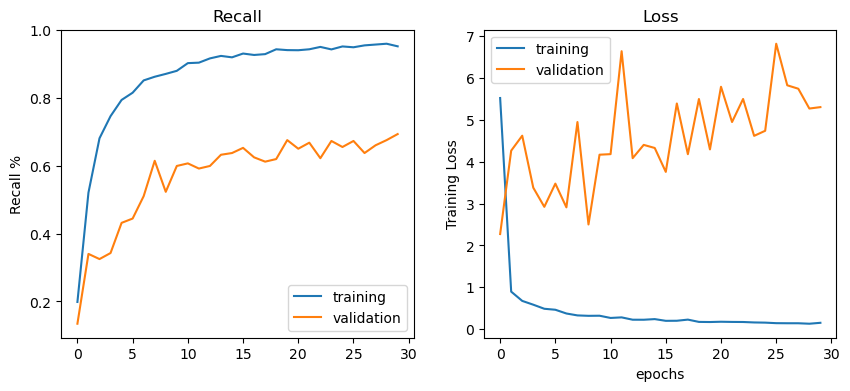

In [128]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch2_cnn1.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch2_cnn1.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch2_cnn1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch2_cnn1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 65ms/step


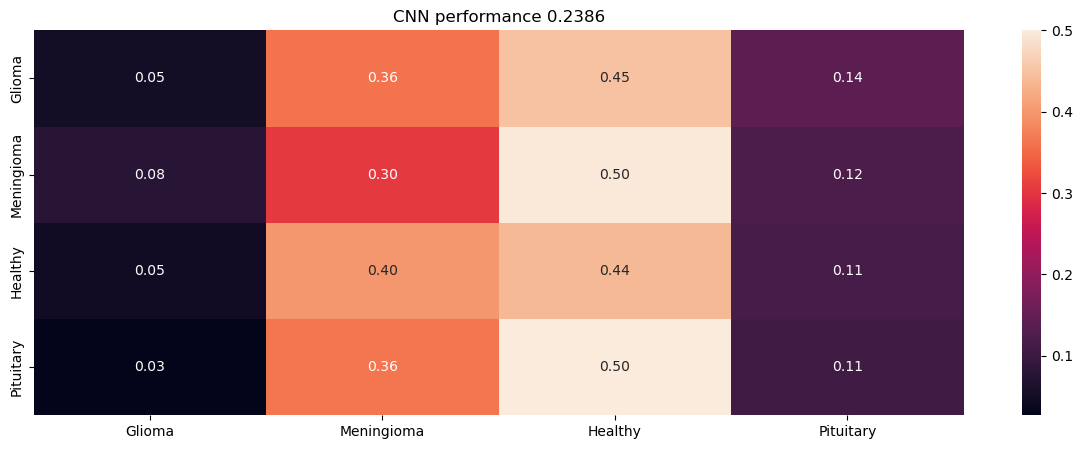

In [129]:
summarize_net(arch2_cnn1, ds_test, title_text='CNN performance')

#### Architecture 2 - Model 2

In [130]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

arch2_cnn2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    arch2_cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    arch2_cnn2.add( MaxPooling2D(pool_size=(2, 2) ) )

# add one layer on flattened output
arch2_cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
arch2_cnn2.add( Flatten() )
arch2_cnn2.add( Dense(64, activation='relu') )
arch2_cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
arch2_cnn2.add( Dense(32, activation='relu') ) # added by me
arch2_cnn2.add( Dense(16, activation='relu') ) # added by me
arch2_cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
arch2_cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

input_shape = [None, 128,128,1]
arch2_cnn2.build(input_shape)
print(cnn_2.summary())

history_arch2_cnn2 = arch2_cnn2.fit(ds_train,
            batch_size=32, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(ds_test))



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 65536)           

90/90 [==============================] - 32s 337ms/step - loss: 3.5061 - recall: 0.2181 - val_loss: 1.5127 - val_recall: 0.0964
Epoch 2/30
90/90 [==============================] - 31s 341ms/step - loss: 0.8591 - recall: 0.5031 - val_loss: 2.0507 - val_recall: 0.2817
Epoch 3/30
90/90 [==============================] - 294s 3s/step - loss: 0.6935 - recall: 0.6383 - val_loss: 2.0626 - val_recall: 0.3223
Epoch 4/30
90/90 [==============================] - 32s 341ms/step - loss: 0.5809 - recall: 0.7111 - val_loss: 1.8691 - val_recall: 0.3680
Epoch 5/30
90/90 [==============================] - 25s 281ms/step - loss: 0.5027 - recall: 0.7610 - val_loss: 1.8521 - val_recall: 0.4340
Epoch 6/30
90/90 [==============================] - 27s 292ms/step - loss: 0.4577 - recall: 0.7864 - val_loss: 1.7850 - val_recall: 0.4822
Epoch 7/30
90/90 [==============================] - 32s 355ms/step - loss: 0.3744 - recall: 0.8230 - val_loss: 2.3031 - val_recall: 0.4797
Epoch 8/30
90/90 [======================

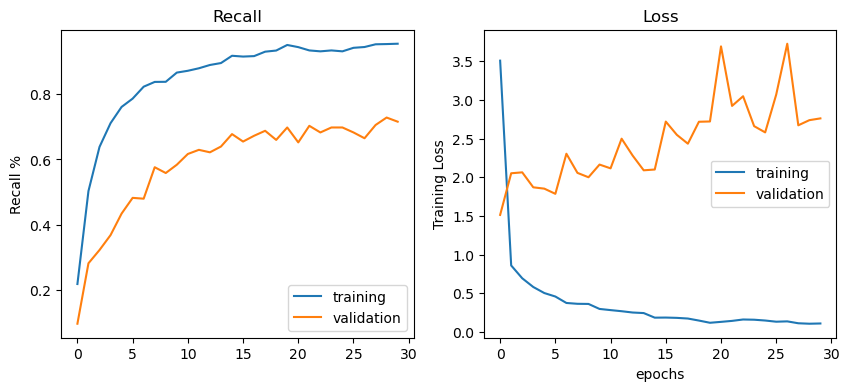

In [131]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch2_cnn2.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch2_cnn2.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch2_cnn2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch2_cnn2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

13/13 [==============================] - 3s 139ms/step


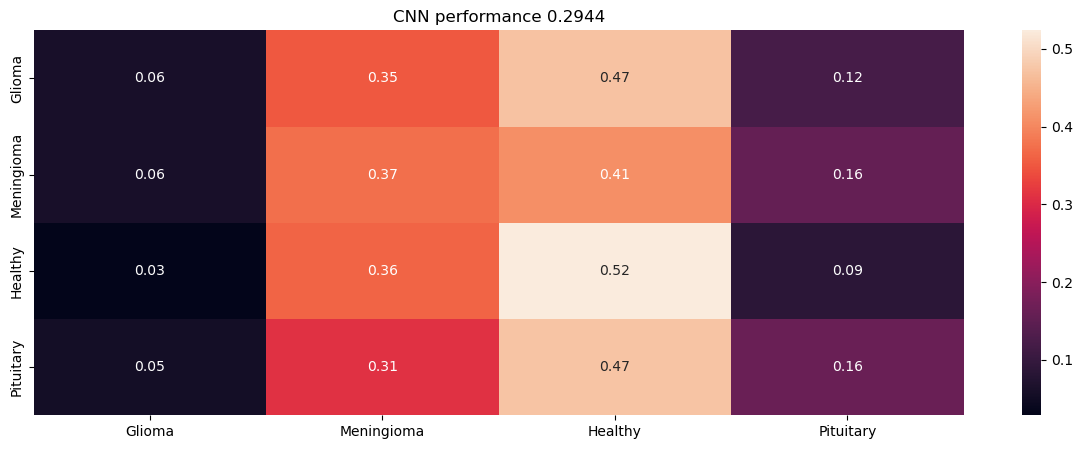

In [132]:
summarize_net(arch2_cnn2, ds_test, title_text='CNN performance')

In [133]:
arch2_cnn2.evaluate(ds_test, verbose=0)

[2.759969711303711, 0.7157360315322876]

#### Comparison of the Four Models

I'll start my model comparison by lookiing at the confusion matricies across all 4.

In [162]:
# Source: Modified from in class lecture to compare two CNNs
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn_1, cnn_2, cnn_3, cnn_4, X_test, y_test, labels='auto'):
    plt.figure(figsize=(12,8))
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    # yhat = np.argmax(net.predict(ds_test), axis=1)
    models_to_compare = [cnn_1, cnn_2, cnn_3, cnn_4]
    model_names = ["Architecture 1 - Model 1",
                   "Architecture 1 - Model 2",
                   "Architecture 2 - Model 1",
                   "Architecture 2 - Model 2"]
    i=1 # use as iterator
    for model in models_to_compare:
        yhat_cnn = np.argmax(model.predict(X_test), axis=1)
        acc = mt.recall_score(y_test,yhat_cnn.squeeze(),average='micro')
        plt.subplot(2,2,i)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'{model_names[i-1]}: {acc:.4f}')
        i+=1
    print(mt.classification_report(y_test,yhat_cnn))



    plt.show()
    

13/13 [==============================] - 2s 104ms/step
              precision    recall  f1-score   support

           0       0.40      0.08      0.13       100
           1       0.35      0.43      0.39       115
           2       0.30      0.53      0.39       105
           3       0.10      0.07      0.08        74

    accuracy                           0.30       394
   macro avg       0.29      0.28      0.25       394
weighted avg       0.30      0.30      0.26       394



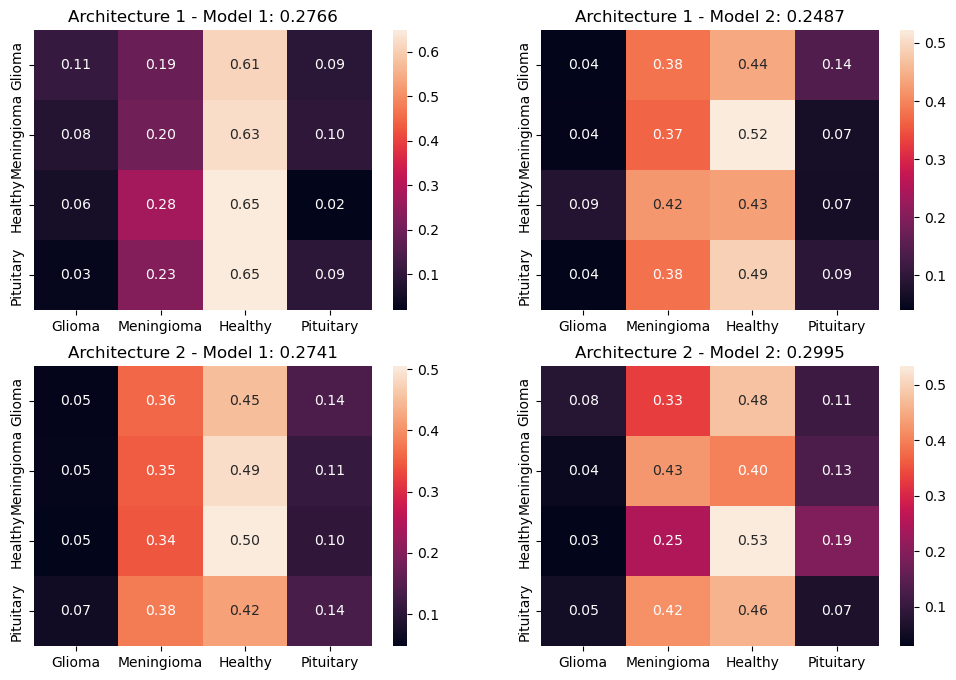

In [163]:
compare_mlp_cnn(arch1_cnn1,
                arch1_cnn2,
                arch2_cnn1,
                arch2_cnn2,
                ds_test,
                ds_test,
                class_names)

Enter some commentary about what these results seem to visually indicate.

Next, I'll perform a statistical comparison to determine if there are really true differences in the two model architectures. 

In [184]:
# Modeified from lab 5 and in-class lecture to use recall
from scipy.stats import t

# Get the histories of recall scores from my two models for comparison
recall_arch1_mod1 = history_arch1_cnn1.history['val_recall']
recall_arch1_mod2 = history_arch1_cnn2.history['val_recall']

# get error rates for both model's f1 scores
arch_1_mod1_err = [1 - f1 for f1 in recall_arch1_mod1]
arch_1_mod2_err = [1 - f1 for f1 in recall_arch1_mod2]

d = []
for err in range(len(arch_1_mod1_err)):
    d.append(arch_1_mod1_err[err] - arch_1_mod2_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 12
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# print(f'The error of the three models is\n', acc1.mean(), '\n', acc2.mean(), '\n', acc3.mean())
print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the first architecture')

Range of: -0.0983201932548031 0.2736163071432257 between the two models in the first architecture


This interval does contain 0. Therefore there is no difference statistically between the first two models sharing the same architecture. Next I'll perform the same for the two models from the second architecture and then an overall comparison.

In [185]:
# Modeified from lab 5 and in-class lecture to use recall
from scipy.stats import t

# Get the histories of recall scores from my two models for comparison
recall_arch2_mod1 = history_arch2_cnn1.history['val_recall']
recall_arch2_mod2 = history_arch2_cnn2.history['val_recall']

# get error rates for both model's f1 scores
arch_2_mod1_err = [1 - f1 for f1 in recall_arch2_mod1]
arch_2_mod2_err = [1 - f1 for f1 in recall_arch2_mod2]

d = []
for err in range(len(arch_2_mod1_err)):
    d.append(arch_2_mod1_err[err] - arch_2_mod2_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 12
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# print(f'The error of the three models is\n', acc1.mean(), '\n', acc2.mean(), '\n', acc3.mean())
print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the second architecture')

Range of: -0.048552215594879676 0.08560805419964779 between the two models in the second architecture


There does appear to be some statistical difference in the two models from the second architecture. I'm seeing a range that does not include 0. 

Looking back at how the models performed, I see a recall score of 0.53 for model 1 of architecture two, compared to a score of 0.07 for the second. Therefore I can say conclusively that architecture 2 model 1 is different, and performs better than model 2 from the same architecture.

Now I'll compare architecture 2 model 1 with one of the models from architecture 1. As pointed out above, the two models from architecture one were statistically the same, so for this comparison which of those two models I pick should be arbitrary. Therefore I'll choose the one that had the best recall score, architecture 1 model 2.

In [186]:
# Modeified from lab 5 and in-class lecture to use recall
# Compare Arch 1 model 2 with arch 2 model 1
from scipy.stats import t

d = []
for err in range(len(arch_1_mod2_err)):
    d.append(arch_1_mod2_err[err] - arch_2_mod1_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 12
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# print(f'The error of the three models is\n', acc1.mean(), '\n', acc2.mean(), '\n', acc3.mean())
print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the second architecture')

Range of: -0.1880570660234575 0.09736331802617358 between the two models in the second architecture


Here, I also see a range that does not include 0 indicating that these two models are statistically different from one another. Therefore looking back at performance meausres with respect to recall:
 -  Arch 1 Mod 2 Recall = 0.43
 -  Arch 2 Mod 1 Recall = 0.53

I can conclusively say that Architecture 2 Model 1 is my best performing model from the perspective of recall.

#### Best Model vs MLP with ROC Curve

I'll start by making a simple multi-layered perceptron model using my test and train data and seeing how it performs.

In [179]:
%%time
# Source: Modified from in-class lecture notebook 11
# CREATE A BASELINE MLP WITH THREE LAYERS

# since this is not binary, we should go ahead and one-hot encode the inputs
# y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
# y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['Recall'])

mlp.fit(ds_train, 
        batch_size=32, epochs=30, 
        shuffle=True, verbose=1)

Epoch 1/30


90/90 [==============================] - 6s 16ms/step - loss: 0.3564 - recall: 0.2871
Epoch 2/30
90/90 [==============================] - 2s 24ms/step - loss: 0.3568 - recall: 0.2864
Epoch 3/30
90/90 [==============================] - 3s 27ms/step - loss: 0.3568 - recall: 0.2864
Epoch 4/30
90/90 [==============================] - 3s 26ms/step - loss: 0.3568 - recall: 0.2864
Epoch 5/30
90/90 [==============================] - 3s 26ms/step - loss: 0.3568 - recall: 0.2864
Epoch 6/30
90/90 [==============================] - 3s 25ms/step - loss: 0.3568 - recall: 0.2864
Epoch 7/30
90/90 [==============================] - 3s 26ms/step - loss: 0.3568 - recall: 0.2864
Epoch 8/30
90/90 [==============================] - 3s 25ms/step - loss: 0.3568 - recall: 0.2864
Epoch 9/30
90/90 [==============================] - 3s 27ms/step - loss: 0.3568 - recall: 0.2864
Epoch 10/30
90/90 [==============================] - 3s 26ms/step - loss: 0.3568 - recall: 0.2864
Epoch 11/30
90/90 [=====================

Revisit this. Need to figure out ROC curve for multiple classes and multiple models. Two graphs of all classes, one for MLP one for CNN?

In [182]:
# Source: Albon, Chris. Machine Learning with Python Cookbook. O'Reilly Media, 20180309.  VitalBook file.
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)

mlp_yhat_proba = np.argmax(mlp.predict(ds_test), axis=1)
cnn_yhat_proba = np.argmax(arch2_cnn1.predict(ds_test), axis=1)


false_positive_rate_mlp, true_positive_rate_mlp, threshold = roc_curve(y_test,
                                                               mlp_yhat_proba)

false_positive_rate_cnn, true_positive_rate_cnn, threshold = roc_curve(y_test,
                                                               cnn_yhat_proba)


# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate_mlp, true_positive_rate_mlp, label='MLP curve')
plt.plot(false_positive_rate_cnn, true_positive_rate_cnn, label='Model 2')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

13/13 [==============================] - 1s 69ms/step


ValueError: multiclass format is not supported

## Transfer Learning

In [188]:
# import os
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [194]:
base_model=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling='max',
    classifier_activation="softmax",
)

for layer in base_model.layers:
    layer.trainable = False
    
model=Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.016),
    Dense(512,kernel_regularizer=regularizers.l2(l= 0.016), activation='relu'),
    Dropout(0.2),
    Dense(64,kernel_regularizer=regularizers.l2(l= 0.016), activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')    
])

In [195]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Recall'])

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_56 (Dense)            (None, 512)               786944    
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                32832     
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                     

In [196]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(

    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_recall",
    mode = "max",
    save_best_only = True
)

In [197]:
history = model.fit(ds_train,
                    epochs = 100,
                    validation_data = ds_test,
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/100
